# Convergence tests of bootstrap covariances for galaxy-forest cross-correlation
We randomly resample (with replacement) both the galaxy positios and Ly-a forest pixels.

*** Here we test the convergence of the bootstrap covariance estimate ***

### Read in galaxy positions and forest pixels.

In [1]:
import numpy as np
import copy
import time as time
import lyafxcorr_kg as xcorr

# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib as mpl
mpl.rc('mathtext',fontset='stixsans')
mpl.rc('figure', facecolor="white")
#matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
#import matplotlib.colors as colors
%matplotlib inline

from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord


# Define cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.31)

# Read in bin edges
PiBin_fil = 'bins23_pi_0-30hMpc.txt'
SigBin_fil = 'bins10_sigma_0-30hMpc.txt'

PiBins0 = ascii.read(PiBin_fil)
SigBins0 = ascii.read(SigBin_fil)

PiEdges = PiBins0['pi_edges'].data
SigEdges = SigBins0['sigma_edges'].data

# Convert bin boundaries from Mpc/h to Mpc
PiEdges  = PiEdges/(len(PiEdges)*[cosmo.h])
SigEdges = SigEdges/(len(SigEdges)*[cosmo.h])
PiBound = (min(PiEdges), max(PiEdges) )

/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/ipykernel/__main__.py:41: DeprecationWarning: bias and ddof have no effect and are deprecated
/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/ipykernel/__main__.py:56: DeprecationWarning: bias and ddof have no effect and are deprecated


Detection significance (full covariance) = 11.718073 sigma
Detection significance (full covariance) = 11.904940 sigma
Detection significance (full covariance) = 12.069705 sigma
(207, 9600)
Detection significance (full sample and covariance)= 11.739108 sigma


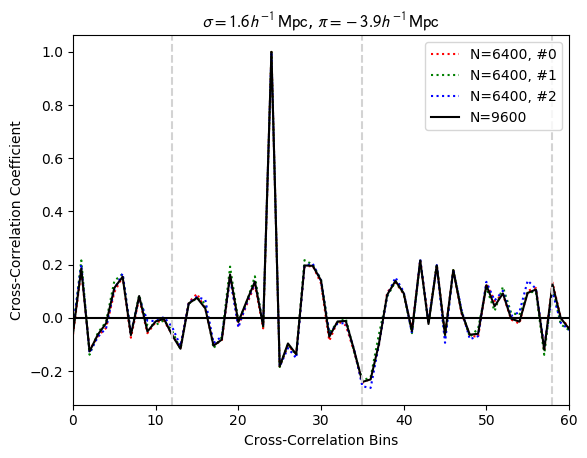

In [6]:

mpcstr = r'$h^{-1}\,\mathrm{Mpc}$'

filesuffix = '_mosdef_'
filesuffix2 = '_MOSDEF_v4_'

XCorr = np.load("xcorr"+filesuffix+"v4.npy")
XNull  = np.load("xcorr_rand"+filesuffix+"v4.npy")
DeltaVec = XCorr.reshape(XCorr.size) - XNull.reshape(XNull.size)

# These are the actual bin centers
PiBins = np.empty(len(PiEdges)-1)
for i in np.arange(len(PiBins)):
    PiBins[i] = (PiEdges[i]+PiEdges[i+1])/2.

SigBins = np.empty(len(SigEdges)-1)
for j in np.arange(len(SigBins)):
    SigBins[j] = (SigEdges[j]+SigEdges[j+1])/2.

XCorrSamples_Tmp1 = np.load("convergence/bootsamp"+filesuffix2+"n9600_1.npy")
XCorrSamples_Tmp2 = np.load("convergence/bootsamp"+filesuffix2+"n9600_2.npy")
#XCorrSamples_Tmp3 = np.load("convergence/bootsamp"+filesuffix2+"n6400_3.npy")
#XCorrSamples_Tmp4 = np.load("bootsamp"+filesuffix+"n3200_4.npy")

XCorrSamples = np.concatenate((XCorrSamples_Tmp1, XCorrSamples_Tmp2), axis=2)
#                               XCorrSamples_Tmp3, XCorrSamples_Tmp4),axis=2)

#XCorrSamples = np.load("bootsamp_vuds_n2048_mpitest.npy")

# Pick one bin to plot the covariances
showbin = 24
showbin2d = np.unravel_index(showbin,(9,16)) #2D bin index

fig, ax = plt.subplots()
color_arr = ['r','g','b','c','y','m']
for i in np.arange(3):
    XCorrSamples_tmp = XCorrSamples[:,:,(i*6400):(i+1)*6400]
    XSampTmp = XCorrSamples_tmp.reshape(-1, XCorrSamples_tmp.shape[-1])
    #print(np.shape(XSampTmp))
    Covar_tmp1 = np.cov(XSampTmp,ddof=0)
    Coeff_tmp1 = np.corrcoef(XSampTmp, ddof=0)
    ax.plot(Coeff_tmp1[showbin,:], color=color_arr[i], linestyle=':',
            label='N=6400, #{}'.format(i))
    #print("Max Covariance is in element: {}".format(np.unravel_index(
    #    np.argmax(Covar_tmp1),(144,144))))
    # This is the matrix with the diagonal variances
    Covar_dummy = Covar_tmp1 # np.diag(np.diag(Covar_tmp1))
    InvCovTmp1 = np.linalg.pinv(Covar_dummy)
    minusLogL = 0.5 * np.dot(DeltaVec.transpose(), np.dot(InvCovTmp1, DeltaVec))
    print("Detection significance (full covariance) = %f sigma" % np.sqrt(minusLogL))
    
XCorrSamples_tmp = XCorrSamples[:,:,:9600]
XSampTmp = XCorrSamples_tmp.reshape(-1, XCorrSamples_tmp.shape[-1])
print(np.shape(XSampTmp))
Covar_tmp1 = np.cov(XSampTmp,ddof=0)
Coeff_tmp1 = np.corrcoef(XSampTmp, ddof=0)
ax.plot(Coeff_tmp1[showbin,:], color='black',label='N={:}'.format(np.shape(XCorrSamples_tmp)[2]))
Covar_dummy = np.diag(np.diag(Covar_tmp1))

# Covariance assume only diagonal; for full set of realizations
#InvCovTmp1 = np.linalg.pinv(Covar_dummy)
#minusLogL = 0.5 * np.dot(DeltaVec.transpose(), np.dot(InvCovTmp1, DeltaVec))
#print("Detection significance (diagonal only)= %f sigma" % np.sqrt(minusLogL))

InvCovTmp1 = np.linalg.pinv(Covar_tmp1)
minusLogL = 0.5 * np.dot(DeltaVec.transpose(), np.dot(InvCovTmp1, DeltaVec))
print("Detection significance (full sample and covariance)= %f sigma" % np.sqrt(minusLogL))

ax.set_xlim((0,60))
ax.set_xlabel('Cross-Correlation Bins')
ax.set_ylabel('Cross-Correlation Coefficient')
sig_str = r'$\sigma={:4.1f}$'.format(SigBins[showbin2d[0]])+mpcstr
pi_str = r'$\pi={:4.1f}$'.format(PiBins[showbin2d[1]])+mpcstr
ax.set_title(sig_str+', '+pi_str)
plt.legend(loc='upper right')
#Draw vertical lines to indicate pi=0
pi0bin = len(PiBins)/2 + 0.5
nlines = 144/len(PiBins)
for i in np.arange(nlines):
    plt.axvline(pi0bin+i*len(PiBins), linestyle='--', color='lightgrey')

plt.axhline(0., color='black')
plt.show()

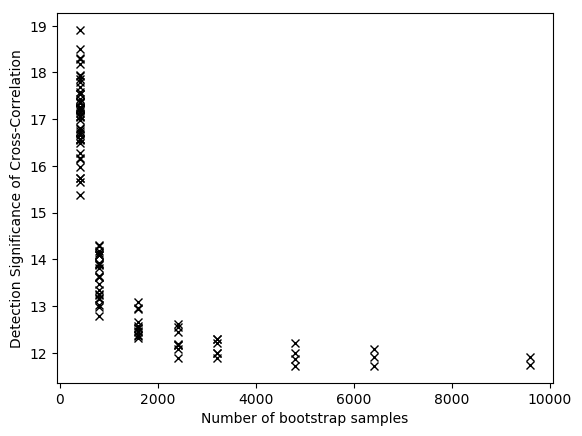

In [5]:
nsamp_tot = np.shape(XCorrSamples)[2]

nboot_bin = (400,800,1600,2400,3200,4800,6400,9600)
nbin = len(nboot_bin)

fig, ax = plt.subplots()

for n in nboot_bin:
    nsplit = np.int(np.floor(nsamp_tot/n))
    for i in np.arange(nsplit):
        XCorrSamples_tmp = XCorrSamples[:,:,(i*n):((i+1)*n)]
        XSampTmp = XCorrSamples_tmp.reshape(-1, XCorrSamples_tmp.shape[-1])
        #print(np.shape(XSampTmp))
        Covar_tmp1 = np.cov(XSampTmp,ddof=0)
        #print("Max Covariance is in element: {}".format(np.unravel_index(
        #    np.argmax(Covar_tmp1),(144,144))))
        # This is the matrix with the diagonal variances
        InvCovTmp1 = np.linalg.pinv(Covar_tmp1)
        minusLogL = 0.5 * np.dot(DeltaVec.transpose(), np.dot(InvCovTmp1, DeltaVec))
        ax.plot(np.asarray(n), np.sqrt(minusLogL), marker='x',color='black')
    
ax.set_xlabel('Number of bootstrap samples')
ax.set_ylabel('Detection Significance of Cross-Correlation')
plt.show()


In [4]:
print(np.sqrt(minusLogL))

11.904295741
